# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

In [1]:
%tensorflow_version 2.x

In [2]:
import tarfile

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2021-12-18 20:16:18--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  15.1MB/s    in 17s     

2021-12-18 20:16:36 (13.7 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [4]:
%%time

tfile = tarfile.open("lfw-funneled.tgz", "r:gz")
tfile.extractall(".")

CPU times: user 5.71 s, sys: 2.45 s, total: 8.16 s
Wall time: 8.22 s


In [56]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.45)

In [57]:
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [58]:
n_samples, h, w

(1140, 56, 42)

In [59]:
X = lfw_people.data
n_features = X.shape[1]

In [60]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
train_x = X_train.reshape(-1, h, w, 1).astype(np.float32) / 255.
test_x = X_test.reshape(-1, h, w, 1).astype(np.float32) / 255.

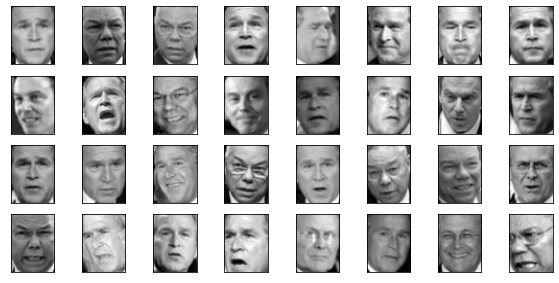

In [63]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(h, w), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Deep Convolutional GAN (DCGAN)

In [93]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*21, activation='relu'),
    tf.keras.layers.Reshape((7, 21, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((4, 1)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [94]:
INPUT_DIM = 100
NUM_EPOCHS = 100
HALF_BATCH_SIZE = 32
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8960; G Loss: 0.7335


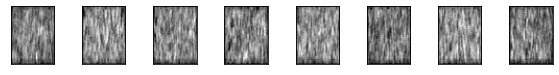

[Step 200] D Loss: 0.1735; G Loss: 0.0057


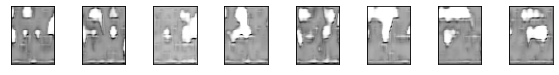

[Step 400] D Loss: 0.5523; G Loss: 7.4358


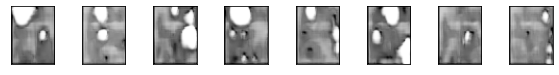

[Step 600] D Loss: 0.2965; G Loss: 2.1896


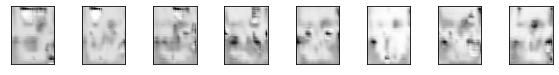

[Step 800] D Loss: 0.4324; G Loss: 3.7531


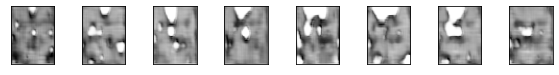

[Step 1000] D Loss: 0.5866; G Loss: 4.6325


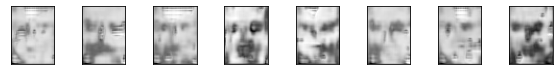

[Step 1200] D Loss: 0.3291; G Loss: 4.1888


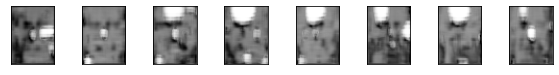

[Step 1400] D Loss: 0.2346; G Loss: 2.5827


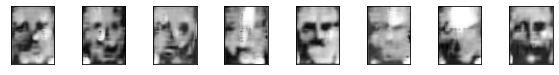

[Step 1600] D Loss: 0.0863; G Loss: 7.4445


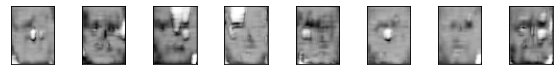

[Step 1800] D Loss: 0.2243; G Loss: 0.5743


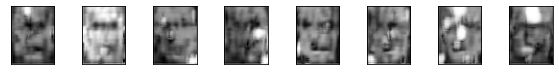

[Step 2000] D Loss: 0.3606; G Loss: 2.8631


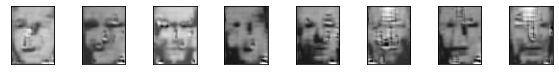

[Step 2200] D Loss: 0.3316; G Loss: 1.0387


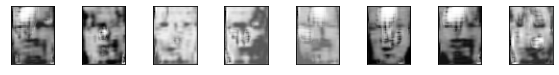

[Step 2400] D Loss: 0.4862; G Loss: 1.9683


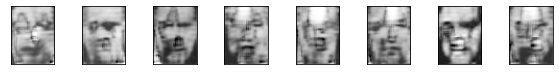

[Step 2600] D Loss: 0.3239; G Loss: 1.6122


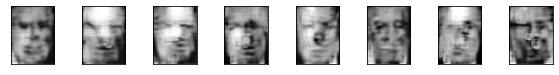

In [95]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Тестирование свёрточного генератора

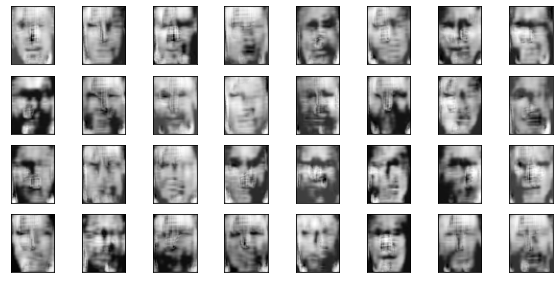

In [96]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

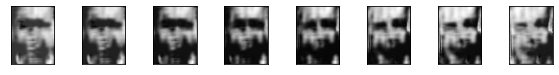

In [97]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)